In [8]:
import os
import glob
import numpy as np
import cv2
import json
import matplotlib.pyplot as plt
from pprint import pprint
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Dense, merge
from keras.models import Model
from keras.layers import Convolution2D, MaxPooling2D, Reshape, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense
from src.learning.processing import parse
from keras.layers import LSTM
from keras.layers.wrappers import TimeDistributed as TD
data_dir = "src/client/pictures/"
data_save_dir = "datasets/npy/"
big_dir = "tawn_dataset/"

def normalize_label(old_val, old_min, old_max, new_min, new_max):
    old_val = float(old_val)
    new_val = (((old_val - old_min) * (new_max - new_min)) / (old_max - old_min)) + new_min
    return new_val

### CAUTION flip only once !

files = parse.get_filenames(data_dir)
flip_dir = data_dir
if not os.path.exists(flip_dir):
    os.makedirs(flip_dir)
    
def flip_angle(label):
    if (label >= 125):
        diff = label - 125
        return 125 - diff
    else:
        diff = 125 - label
        return 125 + diff
    
def flip_dataset(files, directory):
    i = len(files) + 1
    print(len(files))
    for f in files:
        img = cv2.imread(f, 1)
        img = cv2.flip(img, 1)
        f = f.split("_")
        angle = f[1]
        speed = f[2].rstrip(f[2][-4:])
        angle = flip_angle(int(angle))
        img_path = directory + str(i) + "_" + str(angle) + "_" + str(speed) + ".jpg"
        cv2.imwrite(img_path, img)
        print(img_path)
        i += 1
        
flip_dataset(files, data_dir)

In [190]:
for root, dirs, files in os.walk(data_dir):
    for file in files:
        s = file.split("_")
        f = padding_img_id(s[0]) + "_" + s[1] + "_" + s[2]
        os.rename(data_dir + file, data_dir + f)

In [9]:
image_paths = []
angle_labels = []
speed_labels = []
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith(".jpg"):
            filename = os.path.join(root, file)
            image_paths.append(filename)
            s = filename.split("_")
            print("angle:",s[1])
            print("speed:",s[2].rstrip(s[2][-4:]))
            angle_labels.append(float(s[1]))
            speed_labels.append(float(s[2].rstrip(s[2][-4:])))
image_paths = np.array(image_paths)
angle_labels = np.array(angle_labels)
speed_labels = np.array(speed_labels)

angle: 106
speed: 102
angle: 35
speed: 102
angle: 125
speed: 102
angle: 44
speed: 59
angle: 104
speed: 102
angle: 35
speed: 54
angle: 125
speed: 102
angle: 37
speed: 40
angle: 125
speed: 40
angle: 107
speed: 102
angle: 80
speed: 45
angle: 96
speed: 102
angle: 96
speed: 102
angle: 82
speed: 54
angle: 38
speed: 69
angle: 114
speed: 102
angle: 71
speed: 102
angle: 166
speed: 102
angle: 93
speed: 102
angle: 76
speed: 102
angle: 50
speed: 40
angle: 157
speed: 70
angle: 125
speed: 84
angle: 125
speed: 102
angle: 125
speed: 102
angle: 173
speed: 97
angle: 115
speed: 63
angle: 35
speed: 102
angle: 109
speed: 102
angle: 125
speed: 67
angle: 38
speed: 98
angle: 125
speed: 102
angle: 35
speed: 54
angle: 125
speed: 102
angle: 38
speed: 53
angle: 144
speed: 102
angle: 184
speed: 72
angle: 125
speed: 102
angle: 84
speed: 102
angle: 35
speed: 46
angle: 116
speed: 102
angle: 125
speed: 102
angle: 205
speed: 102
angle: 125
speed: 60
angle: 69
speed: 45
angle: 40
speed: 102
angle: 49
speed: 69
angle: 12

angle: 77
speed: 102
angle: 38
speed: 102
angle: 35
speed: 58
angle: 35
speed: 86
angle: 149
speed: 75
angle: 124
speed: 102
angle: 38
speed: 99
angle: 112
speed: 85
angle: 60
speed: 102
angle: 59
speed: 102
angle: 85
speed: 102
angle: 84
speed: 102
angle: 115
speed: 102
angle: 145
speed: 102
angle: 144
speed: 100
angle: 125
speed: 83
angle: 70
speed: 102
angle: 125
speed: 102
angle: 125
speed: 102
angle: 125
speed: 102
angle: 35
speed: 57
angle: 125
speed: 102
angle: 125
speed: 102
angle: 82
speed: 102
angle: 44
speed: 84
angle: 125
speed: 102
angle: 164
speed: 102
angle: 125
speed: 102
angle: 57
speed: 102
angle: 77
speed: 84
angle: 39
speed: 99
angle: 163
speed: 61
angle: 75
speed: 102
angle: 99
speed: 102
angle: 51
speed: 84
angle: 35
speed: 55
angle: 58
speed: 99
angle: 165
speed: 102
angle: 35
speed: 59
angle: 116
speed: 102
angle: 35
speed: 57
angle: 35
speed: 52
angle: 84
speed: 102
angle: 142
speed: 102
angle: 35
speed: 69
angle: 125
speed: 84
angle: 122
speed: 102
angle: 125


speed: 52
angle: 116
speed: 102
angle: 116
speed: 102
angle: 148
speed: 100
angle: 35
speed: 102
angle: 75
speed: 102
angle: 77
speed: 102
angle: 89
speed: 102
angle: 125
speed: 102
angle: 116
speed: 88
angle: 39
speed: 52
angle: 35
speed: 47
angle: 80
speed: 102
angle: 74
speed: 102
angle: 77
speed: 68
angle: 60
speed: 52
angle: 35
speed: 76
angle: 166
speed: 102
angle: 54
speed: 45
angle: 111
speed: 102
angle: 79
speed: 102
angle: 103
speed: 102
angle: 35
speed: 77
angle: 88
speed: 102
angle: 116
speed: 102
angle: 37
speed: 78
angle: 62
speed: 78
angle: 79
speed: 102
angle: 40
speed: 102
angle: 114
speed: 102
angle: 35
speed: 61
angle: 125
speed: 50
angle: 125
speed: 102
angle: 38
speed: 45
angle: 125
speed: 96
angle: 48
speed: 59
angle: 125
speed: 99
angle: 125
speed: 102
angle: 93
speed: 102
angle: 111
speed: 52
angle: 74
speed: 92
angle: 126
speed: 102
angle: 116
speed: 102
angle: 125
speed: 69
angle: 125
speed: 102
angle: 125
speed: 102
angle: 145
speed: 102
angle: 79
speed: 102


speed: 72
angle: 116
speed: 64
angle: 54
speed: 54
angle: 35
speed: 55
angle: 60
speed: 102
angle: 41
speed: 73
angle: 75
speed: 102
angle: 78
speed: 102
angle: 69
speed: 102
angle: 44
speed: 80
angle: 39
speed: 62
angle: 39
speed: 102
angle: 36
speed: 51
angle: 115
speed: 102
angle: 163
speed: 102
angle: 125
speed: 102
angle: 125
speed: 102
angle: 125
speed: 102
angle: 50
speed: 45
angle: 84
speed: 102
angle: 125
speed: 102
angle: 109
speed: 70
angle: 113
speed: 102
angle: 38
speed: 57
angle: 99
speed: 95
angle: 125
speed: 102
angle: 125
speed: 102
angle: 35
speed: 48
angle: 79
speed: 102
angle: 39
speed: 102
angle: 96
speed: 54
angle: 170
speed: 102
angle: 55
speed: 102
angle: 58
speed: 47
angle: 97
speed: 84
angle: 35
speed: 102
angle: 50
speed: 102
angle: 81
speed: 102
angle: 35
speed: 46
angle: 125
speed: 102
angle: 35
speed: 61
angle: 63
speed: 70
angle: 83
speed: 102
angle: 60
speed: 69
angle: 67
speed: 102
angle: 88
speed: 54
angle: 125
speed: 102
angle: 125
speed: 52
angle: 35

In [21]:
(angle_labels.shape, speed_labels.shape, image_paths.shape)

((3587,), (3587,), (3587,))

In [159]:
from random import shuffle

def build_dataset(datas):
    dataset = np.zeros((datas.shape[0], 120, 160, 3))
    for i in range(datas.shape[0]):    
        img = cv2.imread(datas[i])
        img = img[y1:, :]
        img = cv2.resize(img, (160, 120), interpolation = cv2.INTER_CUBIC)
        dataset[i, :, :, :] = img
    return dataset

def build_labels(datas):
    labels = np.array([data[1] for data in datas])
    return to_categorical(labels, 15)


def myGenerator(datas, angle_labels, speed_labels, batch=16):
    i = 0
    while (i < datas.shape[0]):
        if (i == 0):
            loaded_img = build_dataset(datas[:batch])
        else:
            loaded_img = build_dataset(datas[(i - 2):(i + batch)])
        
        nb_batch = i
        x = np.zeros((batch, 3, 120, 160, 3))
        y = np.zeros((batch, 2))
        
        u = 0
        
        while (nb_batch < i + batch and nb_batch < datas.shape[0]):
            for t in range(loaded_img.shape[0]):
                filename = "test" + str(t) + ".png"
                cv2.imwrite(filename, loaded_img[t])
            if (nb_batch == 0):
                x[u, 0, :, :, :] = loaded_img[u]
                x[u, 1, :, :, :] = loaded_img[u]
                x[u, 2, :, :, :] = loaded_img[u]
            elif (nb_batch == 1):
                x[u, 0, :, :, :] = loaded_img[u]
                x[u, 1, :, :, :] = loaded_img[u - 1]
                x[u, 2, :, :, :] = loaded_img[u - 1]
            elif (i == 0):
                x[u, 0, :, :, :] = loaded_img[u]
                x[u, 1, :, :, :] = loaded_img[u - 1]
                x[u, 2, :, :, :] = loaded_img[u - 2]
            else:
                idx = u + 2
                x[u, 0, :, :, :] = loaded_img[idx]
                x[u, 1, :, :, :] = loaded_img[idx - 1]
                x[u, 2, :, :, :] = loaded_img[idx - 2]
            y[u, 0] = angle_labels[nb_batch]
            y[u, 1] = speed_labels[nb_batch]
            nb_batch += 1
            u += 1
        print(x.shape, y.shape)
        yield x, y
        i += batch

In [160]:
gen = myGenerator(image_paths, angle_labels, speed_labels, 16)

In [164]:
x, y = next(gen)

(16, 3, 120, 160, 3) (16, 2)


In [127]:
#cv2.imwrite("test.png", x[0][0])
x[0][0].shape

(120, 160, 3)

In [54]:
data = np.zeros((image_paths.shape[0], 120, 160, 3))
for i in range(image_paths.shape[0]):
    img = cv2.imread(image_paths[i])
    y1 = int(img.shape[0] / 2)
    img = img[y1:, :]
    img = cv2.resize(img, (160, 120), interpolation = cv2.INTER_CUBIC)
    data[i] = img

KeyboardInterrupt: 

In [12]:
data.shape

(3587, 120, 160, 3)

In [13]:
angle_labels = ((angle_labels - 35) / 170.0 - 0.5) * 2
idx = 0
for spd in speed_labels:
    speed_labels[idx] = normalize_label(spd, 40, 102, 0, 1)
    idx += 1

In [14]:
print(str(speed_labels))

[ 1.          1.          1.         ...,  0.11290323  0.51612903  1.        ]


In [15]:
print(str(angle_labels))

[-0.16470588 -1.          0.05882353 ..., -1.         -0.55294118
  0.22352941]


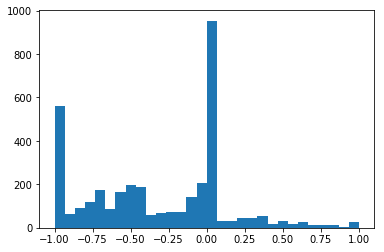

In [16]:
plt.hist(angle_labels, bins=30)
plt.show()

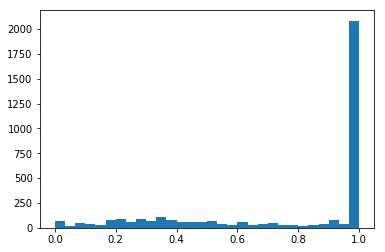

In [17]:
plt.hist(speed_labels, bins=30)
plt.show()

In [ ]:
def AnglePredCnn():
    img_in = Input(shape=(120, 160, 3), name='img_in')                      # First layer, input layer, Shape comes from camera.py resolution, RGB
    x = img_in
    x = Convolution2D(24, (5,5), strides=(2,2), activation='relu')(x)       # 24 features, 5 pixel x 5 pixel kernel (convolution, feauture) window, 2wx2h stride, relu activation
    x = Convolution2D(32, (5,5), strides=(2,2), activation='relu')(x)       # 32 features, 5px5p kernel window, 2wx2h stride, relu activatiion
    x = Convolution2D(64, (5,5), strides=(2,2), activation='relu')(x)       # 64 features, 5px5p kernal window, 2wx2h stride, relu
    x = Convolution2D(64, (3,3), strides=(2,2), activation='relu')(x)       # 64 features, 3px3p kernal window, 2wx2h stride, relu
    x = Convolution2D(64, (3,3), strides=(1,1), activation='relu')(x)       # 64 features, 3px3p kernal window, 1wx1h stride, relu

    # Possibly add MaxPooling (will make it less sensitive to position in image).  Camera angle fixed, so may not to be needed

    x = Flatten(name='flattened')(x)                                        # Flatten to 1D (Fully connected)
    x = Dense(100, activation='linear')(x)                                    # Classify the data into 100 features, make all negatives 0
    x = Dropout(.1)(x)                                                      # Randomly drop out (turn off) 10% of the neurons (Prevent overfitting)
    x = Dense(50, activation='linear')(x)                                     # Classify the data into 50 features, make all negatives 0
    x = Dropout(.1)(x)                                                      # Randomly drop out 10% of the neurons (Prevent overfitting)
    #categorical output of the angle
    angle_out = Dense(1, activation='linear', name='angle_out')(x)        # Connect every input with every output and output 15 hidden units. Use Softmax to give percentage. 15 categories and find best one based off percentage 0.0-1.0
    
    #continous output of throttle
    throttle_out = Dense(1, activation='linear', name='throttle_out')(x)      # Reduce to 1 number, Positive number only
    
    model = Model(inputs=[img_in], outputs=[angle_out, throttle_out])
    model.compile(optimizer='adam',
                  loss={'angle_out': 'mean_squared_error',
                        'throttle_out': 'mean_squared_error'},
                  loss_weights={'angle_out': 0.9, 'throttle_out': .001})
    return model



In [2]:
def rnn_lstm(seq_length=3, num_outputs=2, image_shape=(120,160,3)):

    img_seq_shape = (seq_length,) + image_shape   
    img_in = Input(batch_shape = img_seq_shape, name='img_in')
    
    x = Sequential()
    #x.add(TD(Cropping2D(cropping=((60,0), (0,0))), input_shape=img_seq_shape )) #trim 60 pixels off top
    x.add(TD(Convolution2D(24, (5,5), strides=(2,2), activation='relu'), input_shape=img_seq_shape))
    x.add(TD(Convolution2D(32, (5,5), strides=(2,2), activation='relu')))
    x.add(TD(Convolution2D(64, (3,3), strides=(2,2), activation='relu')))
    x.add(TD(Convolution2D(64, (3,3), strides=(1,1), activation='relu')))
    x.add(TD(Convolution2D(64, (3,3), strides=(1,1), activation='relu')))
    x.add(TD(Flatten(name='flattened')))
    x.add(TD(Dense(100, activation='relu')))
    x.add(TD(Dropout(.1)))
      
    x.add(LSTM(128, return_sequences=True, name="LSTM_seq"))
    x.add(Dropout(.1))
    x.add(LSTM(128, return_sequences=False, name="LSTM_out"))
    x.add(Dropout(.1))
    x.add(Dense(50, activation='relu'))
    x.add(Dropout(.1))
    x.add(Dense(num_outputs, activation='linear', name='model_outputs'))
    
    x.compile(optimizer='adam', loss='mse')
    
    print(x.summary())

    return x

In [3]:
model = rnn_lstm()

NameError: name 'Sequential' is not defined

In [ ]:
model_path = os.path.abspath("models/speed_model.h5")
checkpointer = ModelCheckpoint(model_path, save_best_only=True, monitor='val_loss', mode='min')
hist = model.fit(data, [angle_labels, speed_labels], validation_split=0.1, epochs=6, batch_size=16, callbacks=[checkpointer])

In [ ]:
model.summary()

In [ ]:
plt.plot(hist.history["loss"][1:])
plt.plot(hist.history["val_loss"][1:])
plt.show()

In [ ]:
model.save("models/new_cam.h5")

In [ ]:
plt.hist(model.predict(data)[0], bins=30)
plt.show()

In [ ]:
plt.hist(labels, bins=30)
plt.show()

In [ ]:
data.shape

In [ ]:
labels.shape

In [ ]:
mask = np.where((labels > -0.08) & (labels < 0.08))
mask = (np.random.choice(mask[0], int(2 * mask[0].shape[0] / 3), replace=False),)

maska = np.ones(labels.shape,dtype=bool)
maska[mask] = False

In [ ]:
labels[maska].shape

In [ ]:
labels = labels[maska]
data = data[maska]

In [ ]:
plt.hist(labels, bins=30)
plt.show()

In [ ]:
test = myGenerator(image_paths, labels, 16)
for j in range(0, 4):
    x, y = next(test)
    print(x.shape)
    print(y.shape)